In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

# Load the TensorBoard notebook extension.
%load_ext tensorboard

TensorFlow 2.x selected.
2.1.0


In [3]:
# Clear logs from previous calls
!rm -rf ./logs/ 

# Check
!ls

model.png  sample_data	training


In [0]:
# Download the daset with keras.utils.get_file
dataset_path = keras.utils.get_file("housing.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data")

## Boston house prices dataset

#### Characteristics
* Number of Instances: 506
* The first 13 features are numeric/categorical predictive features. 
* The last one (attribute 14): Median Value is the target variable.

#### Attributes

1. CRIM per capita crime rate by town
2. ZN proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS proportion of non-retail business acres per town
4. CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. NOX nitric oxides concentration (parts per 10 million)
6. RM average number of rooms per dwelling
7. AGE proportion of owner-occupied units built prior to 1940
8. DIS weighted distances to five Boston employment centres
9. RAD index of accessibility to radial highways
10. TAX full-value property-tax rate per \$10,000
11. PTRATIO pupil-teacher ratio by town
12. B 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. LSTAT \% lower status of the population
14. MEDV Median value of owner-occupied homes in \$1000’s [target attribute]

In [5]:
column_names = ['CRIM','ZN','INDUS','CHAS','NOX',
                'RM', 'AGE', 'DIS','RAD','TAX','PTRATION', 'B', 'LSTAT', 'MEDV']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)
# Create a dataset instant
dataset = raw_dataset.copy()

# This function returns last n rows from the object 
# based on position.
dataset.tail(n=10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATION,B,LSTAT,MEDV
496,0.28960,0.0,9.69,0,0.585,5.390,72.9,2.7986,6,391.0,19.2,396.90,21.14,19.7
497,0.26838,0.0,9.69,0,0.585,5.794,70.6,2.8927,6,391.0,19.2,396.90,14.10,18.3
498,0.23912,0.0,9.69,0,0.585,6.019,65.3,2.4091,6,391.0,19.2,396.90,12.92,21.2
499,0.17783,0.0,9.69,0,0.585,5.569,73.5,2.3999,6,391.0,19.2,395.77,15.10,17.5
500,0.22438,0.0,9.69,0,0.585,6.027,79.7,2.4982,6,391.0,19.2,396.90,14.33,16.8
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0,0.573,6.030,80.8,2.5050,1,273.0,21.0,396.90,7.88,11.9


### Data processing (train/test split)

In [0]:
# Split data into train/test
# p = training data portion
p=0.8
trainDataset = dataset.sample(frac=p,random_state=0)
testDataset = dataset.drop(trainDataset.index)

## linear regression with one variable

Here, we desire to model the relationship between the dependent variable and the independent variable. In the linear regression with one variable, *we only have **one** independent variable*.

* Independent variable: 'RM'
* Dependent variable: 'MEDV'

In a simple word, we want to **predict** the Median value of owner-occupied homes in $1000’s [target attribute] based on the average number of rooms per dwelling (RM).

### Plot dependecy to one variable (linear regression with one variable)

Here we want to plot the MEDV against RM, i.e, visualize how MEDV is changed by changing RM. Basically we have $MEDV=f(RM)$ and we desire to estimate the function $f(.)$ using a linear regression.



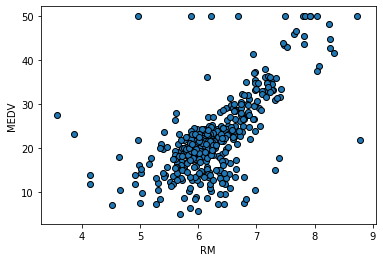

In [7]:
# Visual representation of training data
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
# With .pop() command, the associated columns are extracted.
x = trainDataset['RM']
y = trainDataset['MEDV']
ax.scatter(x, y, edgecolors=(0, 0, 0))
ax.set_xlabel('RM')
ax.set_ylabel('MEDV')
plt.show()

### Split train/test data and labels for linear regression for one variable experiments

We can use two approaches to access the columns:

1. **Pop command:** It returns an item and drops it from the frame. After using trainDataset.pop('RM'), the 'RM' column does not exist in the trainDataset frame anymore!
2. Using the **indexing with labels**. Example trainDataset['RM']

We use approach **(2)**.

In [0]:
# Pop command return item and drop it from frame.
# After using trainDataset.pop('RM'), the 'RM' column 
# does not exist in the trainDataset frame anymore!
trainInput = trainDataset['RM']
trainTarget = trainDataset['MEDV']
testInput = testDataset['RM']
testTarget = testDataset['MEDV']

### Data normalization/standardization

*It is not needed for simple linear regression (linear regression with one variable).*

1. **Standardization**: Standardizing the features around the center and 0 with a standard deviation of 1. Assume we have features that have different units. So just becasue of the scaling do not contribute equally to the analysis and create misleading result. Formula: $\hat{X}=\frac{X-\mu}{\sigma}$

2. **Normalization**: Normalization aims to put the values of different features to a common scale (usually [0,1] or [-1,1]). This is used when features have different ranges but the same units. **Example**: Assume we have an RGB image. *Each channel has a different range but all channels have the same units: image pixel*! Formula: $\hat{X}=\frac{X-X_{min}}{X_{max}-X_{min}}$

### Create Model

1. The architecture of the model
2. Defining the optimizer
3. Compile the model and return the graph

Assume we desire to find the parameters (**W**) that predict the
output y from x in a linear fashion:

$y = w_1 x + w_0$

The above can be defined with the following dense layer:

*layers.Dense(1, use_bias=True, input_shape=(1,))*


In [9]:
# We don't specify anything for activation -> no activation is applied (ie. "linear" activation: a(x) = x)
# Check: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense

def linear_model():
  model = keras.Sequential([
        layers.Dense(1, use_bias=True, input_shape=(1,), name='layer')
      ])

  # Using adam optimizer
  optimizer = tf.keras.optimizers.Adam(
      learning_rate=0.01, beta_1=0.9, beta_2=0.99, epsilon=1e-05, amsgrad=False,
      name='Adam')
    
  # Check: https://www.tensorflow.org/api_docs/python/tf/keras/Model
  # loss: String (name of objective function), objective function or tf.keras.losses.Loss instance. See tf.keras.losses.
  # optimizer: String (name of optimizer) or optimizer instance. See tf.keras.optimizers.
  # metrics: List of metrics to be evaluated by the model during training and testing
  model.compile(loss='mse', optimizer=optimizer, metrics=['mae','mse'])

  return model

# Create model instant
model = linear_model()

# Model plot
tf.keras.utils.plot_model(
  model, to_file='model.png', show_shapes=True, show_layer_names=True,
  rankdir='TB', expand_nested=False, dpi=100
  )

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


### Training loop
Fit the model to the data

* n_epochs: number of epochs
* validation_split: keep a portion of training data for unbiased validation
* verbose: set to 0 as we want a short summary and not all the details!!
* callbacks: A callback is a tool to customize the behavior of a the model during training, testing, etc.

In [10]:
# params
n_epochs = 4000
batch_size = 256
n_idle_epochs = 100
n_epochs_log = 200
n_samples_save = n_epochs_log * trainInput.shape[0]
print('Checkpoint is saved for each {} samples'.format(n_samples_save))

# A mechanism that stops training if the validation loss is not improving for more than n_idle_epochs.
#See https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping for details.
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=n_idle_epochs, min_delta=0.001)

# Creating a custom callback to print the log after a certain number of epochs
# Check: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
predictions_list = []
class NEPOCHLogger(tf.keras.callbacks.Callback):
    def __init__(self,per_epoch=100):
        '''
        display: Number of batches to wait before outputting loss
        '''
        self.seen = 0
        self.per_epoch = per_epoch
    
    def on_epoch_end(self, epoch, logs=None):
      if epoch % self.per_epoch == 0:
        print('Epoch {}, loss {:.2f}, val_loss {:.2f}, mae {:.2f}, val_mae {:.2f}, mse {:.2f}, val_mse {:.2f}'\
              .format(epoch, logs['loss'], logs['val_loss'],logs['mae'], logs['val_mae'],logs['mse'], logs['val_mse']))
              
# Call the object
log_display = NEPOCHLogger(per_epoch=n_epochs_log)

# Include the epoch in the file name (uses `str.format`)
import os
checkpoint_path = "training/cp-{epoch:05d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
checkpointCallback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=n_samples_save)

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(
  trainInput, trainTarget, batch_size=batch_size,
  epochs=n_epochs, validation_split = 0.1, verbose=0, callbacks=[earlyStopping,log_display,tensorboard_callback,checkpointCallback])

Checkpoint is saved for each 81000 samples
Epoch 0, loss 488.58, val_loss 572.57, mae 20.36, val_mae 21.62, mse 488.58, val_mse 572.57
Epoch 200, loss 56.56, val_loss 95.96, mae 5.27, val_mae 6.86, mse 56.56, val_mse 95.96

Epoch 00223: saving model to training/cp-00223.ckpt
Epoch 400, loss 54.51, val_loss 91.51, mae 5.27, val_mae 6.76, mse 54.51, val_mse 91.51

Epoch 00446: saving model to training/cp-00446.ckpt
Epoch 600, loss 52.85, val_loss 90.09, mae 5.19, val_mae 6.66, mse 52.85, val_mse 90.09

Epoch 00669: saving model to training/cp-00669.ckpt
Epoch 800, loss 51.21, val_loss 88.87, mae 5.10, val_mae 6.56, mse 51.21, val_mse 88.87

Epoch 00892: saving model to training/cp-00892.ckpt
Epoch 1000, loss 49.67, val_loss 88.08, mae 4.98, val_mae 6.46, mse 49.67, val_mse 88.08

Epoch 01115: saving model to training/cp-01115.ckpt
Epoch 1200, loss 48.39, val_loss 87.45, mae 4.89, val_mae 6.39, mse 48.39, val_mse 87.45

Epoch 01338: saving model to training/cp-01338.ckpt
Epoch 1400, loss 

In [0]:
# %tensorboard --logdir logs

keys: dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])


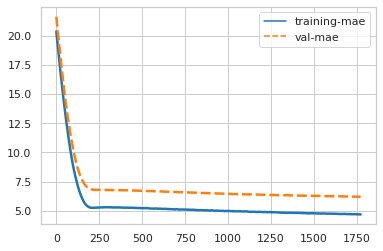

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns

# The fit model returns the history object for each Keras model
# Let's explore what is inside history
print('keys:', history.history.keys())

# Returning the desired values for plotting and turn to numpy array
mae = np.asarray(history.history['mae'])
val_mae = np.asarray(history.history['val_mae'])

# Creating the data frame
num_values = (len(mae))
values = np.zeros((num_values,2), dtype=float)
values[:,0] = mae
values[:,1] = val_mae

# Using pandas to frame the data
steps = pd.RangeIndex(start=0,stop=num_values)
data = pd.DataFrame(values, steps, columns=["training-mae", "val-mae"])

# Plotting
sns.set(style="whitegrid")
sns.lineplot(data=data, palette="tab10", linewidth=2.5)

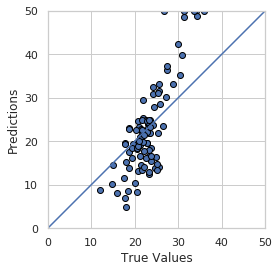

In [13]:
predictions = model.predict(testInput).flatten()
a = plt.axes(aspect='equal')
plt.scatter(predictions, testTarget, edgecolors=(0, 0, 0))
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

### Track the model improvement progression

In [14]:
# Get the saved checkpoint files
checkpoints = []
for f_name in os.listdir(checkpoint_dir):
  if f_name.startswith('cp-'):
    file_with_no_ext = os.path.splitext(f_name)[0]
    checkpoints.append(file_with_no_ext)

# Return unique list elements
checkpoints = list(set(checkpoints))
print('checkpoints:',checkpoints)

# Load all model checkpoints and evaluate for each
count = 0
model_improvement_progress = False
if model_improvement_progress:
  for checkpoint in checkpoints:
    count += 1

    # Call model instant
    model = linear_model()
    
    # Restore the weights
    path = os.path.join('training',checkpoint)
    model.load_weights(path)

    # Access to layer weights
    layer = model.get_layer('layer')
    w1,w0 = layer.get_weights()
    w1 = float(w1[0])
    w0 = float(w0[0])
    
    # Draw the scatter plot of data
    fig, ax = plt.subplots()
    x = testInput
    y = testTarget
    ax.scatter(x, y, edgecolors=(0, 0, 0))
    ax.set_xlabel('RM')
    ax.set_ylabel('MEDV')
    
    # Plot the line
    y_hat = w1*x + w0
    plt.plot(x, y_hat, '-r')
    plt.savefig(os.path.join('/content/drive/linearregression', str(checkpoint)+'.png'))


checkpoints: ['cp-00669.ckpt', 'cp-01784.ckpt', 'cp-01338.ckpt', 'cp-02007.ckpt', 'cp-00000.ckpt', 'cp-01561.ckpt', 'cp-01115.ckpt', 'cp-00892.ckpt', 'cp-00223.ckpt', 'cp-00446.ckpt']
